# Example2: Localization for single events

In this notebook I will show how to localize a GW event with seal.

In [1]:
import bilby
import numpy as np 
import time
import sys
import matplotlib.pyplot as plt
from multiprocessing import Pool
import multiprocessing
from functools import partial
from matplotlib.pyplot import MultipleLocator
from bilby.gw import conversion
from scipy.optimize import leastsq
import json
from pycbc.filter import matched_filter,matched_filter_core
from pycbc.types.timeseries import TimeSeries
from pycbc.types.frequencyseries import FrequencySeries
from lal import LIGOTimeGPS

import sealgw
from sealgw import seal
import sealgw.calculation as sealcal
import sealgw.simulation as sealsim

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Case I: Localizing SPIIR trigger events

Seal is going to be implemented in SPIIR, here I show how to process .xml file from SPIIR and localize it.

### Extract information and do it manually

You can extract event information from xml file and provide it to Seal manually. Same function can be used for your own GW events.


In [2]:
# Initialize Seal

seal_O2 = seal.Seal('example_outputs/sealconfig_O2_lhv_BNS.txt') # use the config we fit in example1
xml_filepath = 'example_inputs/H1L1V1_1187008882_3_806.xml'

# extract_info_from_xml returns a lot of useful data that seal needs
# return_names==True: return det names
# return_names==False: return det codes
#  Note here snr_arrays, time_arrays are 1-D arrays, SNR series and timestamps from different detectors are connected to 1-D. 
#  ntimes_array stores the length of each detector, i.e., 
#  the first ntimes_array[0] elements in snr_arrays, is the snr series of 1st detector. Same for timestamps.
#  from ntimes_array[0]+1 to ntimes_array[0]+ntimes_array[1] are elements for 2nd detector.
#  Seal.localize take 1-D array, here is auto-converted when reading xml file. But if you are using your own SNR, remember to convert.
#  See simulation examples below.
trigger_time, ndet, ntimes_array, det_names, max_snr_array, sigma_array, time_arrays, snr_arrays =\
        sealcal.localization.extract_info_from_xml(xml_filepath, return_names=True)

#can be converted with:
#det_codes_array = sealcal.localization.get_det_code_array(det_names)

xml processing done. 
Trigger time: 1187008882.4453125
Detectors: ['H1', 'L1', 'V1']
SNRs: [15.10651112 24.52303505  1.96168923]
sigmas: [1969.1236365  1677.65263077  912.23831788]


In [3]:
########### Reload some event info because xml has some errors ###########
#trigger_time = 1187008882.44
posttime_fix = 0.01  # trigger time is the end time, we assume peak time always < end time, so subtract this fix factor
time_prior_width = 0.021  # Earth radius / light speed
start_time = trigger_time - time_prior_width - posttime_fix
end_time = trigger_time + time_prior_width - posttime_fix
sigma_array = np.array([142*8.0,213*8.0,60*8.0])
print("Times and horizons are manually corrected.")
########### Delete above when xml issues are fixed ###########

Times and horizons are manually corrected.


In [4]:
# localize with seal. If you set timecost=False, it doesn't return timecost.

nthread =4  # number of threads you want to use
max_snr = sum(snr**2 for snr in max_snr_array)
max_snr = max_snr**0.5
logprob_skymap, timecost = seal_O2.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread, interp_factor=8, timecost=True)

print("Timecost (s): ", timecost)

Timecost (s):  1.0988609790802002


Skymap saved to example_outputs/skymap_GW170817.pdf


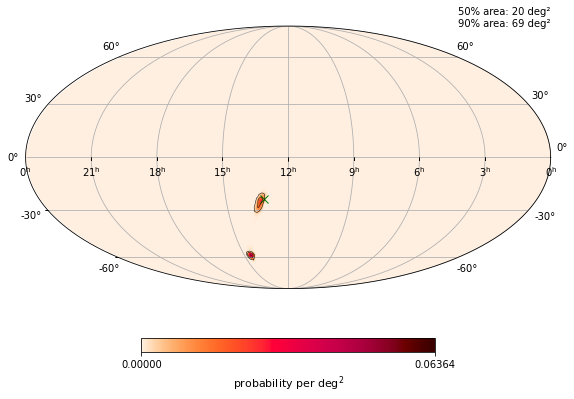

In [5]:
# plot it.
save_filename = 'example_outputs/skymap_GW170817.pdf'
true_ra = 3.446
true_dec = -0.408
sealcal.localization.plot_skymap(logprob_skymap, save_filename=save_filename, true_ra = true_ra, true_dec = true_dec)

To save the log_prob as .fits file, we can simply use ligo.skymap:

In [6]:
import ligo.skymap.io.fits
from datetime import datetime
fits_file_name = 'example_outputs/skymap_GW170817.fits'
now = datetime.now()
dt_string = now.strftime("%Y-%m-%dT%H:%M:%S")
fits_createtime = dt_string

# To do: check if vcs_version, vcs_revision, build_date are what needed.
# https://lscsoft.docs.ligo.org/ligo.skymap/_modules/ligo/skymap/io/fits.html#read_sky_map
ligo.skymap.io.fits.write_sky_map(fits_file_name, logprob_skymap, nest=True,
                vcs_version='SealGW 0.01', vcs_revision='bar',
                build_date=dt_string)

and read from .fits:

In [7]:
logprob_skymap_from_fits = ligo.skymap.io.fits.read_sky_map(fits_file_name,  nest=True)
logprob_skymap_from_fits

(array([ 34.15080295,  34.15080295,  34.15080295, ..., 225.64540859,
        225.64540859, 225.64540859]),
 OrderedDict([('nest', True),
              ('vcs_version', 'SealGW 0.01'),
              ('vcs_revision', 'bar'),
              ('build_date', '2023-01-09T13:57:36')]))

In [8]:
# check if they are the same array
(logprob_skymap_from_fits[0] == logprob_skymap).all()

True

### Let seal do it automatically

The above process can be done by seal. It's convenient to let seal do this inside, but you cannot see what info is stored in xml.

...waiting to fix trigger time and sigma issue in xml...

## Case II: Localizing your simulation events

Seal provides snr_generator to help you generate SNR timeseries (in the format of pycbc timeseries) and sigmas. 

You just need to provide detector, waveform generator, injection parameter (in bilby style), call the snr_generator, and pass the variables. You may need to reshape some variables before passing.

## BNS

In [9]:
injection_parameters = dict(mass_1 = 1.4, mass_2 = 1.4, chi_1=0.02, chi_2=0.01, lambda_1=425, lambda_2=425,
                            luminosity_distance=100., theta_jn=0.4, psi=2.6, phase=1.3, geocent_time=1126259642.4, ra=2.1, dec=1.2)

duration = 320. # 16
sampling_frequency = 4096


waveform_arguments = dict(waveform_approximant='TaylorF2', minimum_frequency=20.)


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    waveform_arguments=waveform_arguments)

det_names = ['H1', 'L1', 'V1']

ifos = bilby.gw.detector.InterferometerList(det_names)

psd_files = ['example_inputs/H1_psd.txt','example_inputs/L1_psd.txt', 'example_inputs/V1_psd.txt']
# if your want to use your own PSD
for i in range(len(ifos)):
    det = ifos[i]
    psd_file = psd_files[i]
    psd = bilby.gw.detector.PowerSpectralDensity(psd_file=psd_file)
    det.power_spectral_density = psd 

ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration + 1)

ifos.inject_signal(waveform_generator=waveform_generator,
                parameters=injection_parameters)



13:57 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:57 bilby INFO    : Injected signal in H1:
13:57 bilby INFO    :   optimal SNR = 7.22
13:57 bilby INFO    :   matched filter SNR = 7.13+0.44j
13:57 bilby INFO    :   mass_1 = 1.4
13:57 bilby INFO    :   mass_2 = 1.4
13:57 bilby INFO    :   chi_1 = 0.02
13:57 bilby INFO    :   chi_2 = 0.01
13:57 bilby INFO    :   lambda_1 = 425
13:57 bilby INFO    :   lambda_2 = 425
13:57 bilby INFO    :   luminosity_distance = 100.0
13:57 bilby INFO    :   theta_jn = 0.4
13:57 bilby INFO    :   psi = 2.6
13:57 bilby INFO    :   phase = 1.3
13:57 bilby INFO    :   geocent_time = 1126259642.4
13:57 bilby INFO    :   ra = 2.1
13:57 bilby INFO    :   dec = 1.2
13:57 bilby INFO    : Injected signal in L1:
13:57 bilby INFO    :   optimal SNR = 9.38
13:57 bilby 

[{'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -4.10580446e-27-1.16500555e-25j, -4.09971980e-27-1.16500562e-25j,
         -4.09363520e-27-1.16500568e-25j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -1.16107796e-25+4.09196253e-27j, -1.16107803e-25+4.08589838e-27j,
         -1.16107809e-25+4.07983430e-27j])},
 {'plus': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -4.10580446e-27-1.16500555e-25j, -4.09971980e-27-1.16500562e-25j,
         -4.09363520e-27-1.16500568e-25j]),
  'cross': array([ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
          0.00000000e+00+0.00000000e+00j, ...,
         -1.16107796e-25+4.09196253e-27j, -1.16107803e-25+4.08589838e-27j,
         -1.16107809e-25+4.07983430e-27j])},


In [10]:
# Generate SNR and sigma
snr_list, sigma_list = sealsim.generating_data.snr_generator(ifos, waveform_generator, injection_parameters)

injection tc:  1126259642.4
Max snr time: 1126259642.3865724, SNR = 7.179422256913543


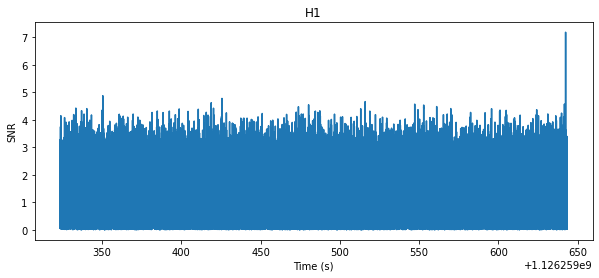

Max snr time: 1126259642.387549, SNR = 10.02639795366712


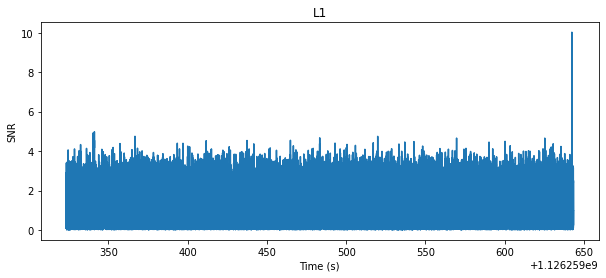

Max snr time: 1126259642.3821778, SNR = 5.961391772418911


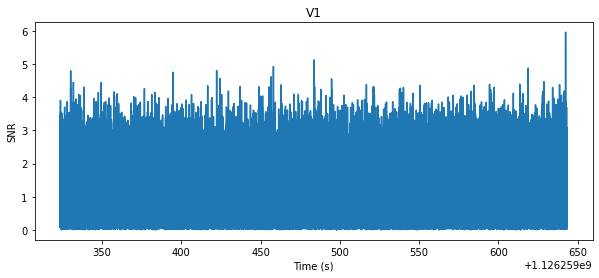

Max network SNR:  13.69711472291262


In [11]:
# Take a look at SNR we have
print('injection tc: ', injection_parameters['geocent_time'])
max_snr_sq = 0

det_id = 0
for snr in snr_list:
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    max_snr_sq += abs(snrp)**2
    time = snr.sample_times[peak]
    print('Max snr time: {}, SNR = {}'.format( time , abs(snrp)) )
    
    plt.figure(figsize=[10, 4])
    plt.plot(snr.sample_times, abs(snr))
    plt.ylabel('SNR')
    plt.xlabel('Time (s)')
    plt.title(det_names[det_id])
    plt.show()
    
    det_id +=1

print('Max network SNR: ', max_snr_sq**0.5)

In [12]:

nthread = 4

det_names = ['H1', 'L1', 'V1']

# Rearrange some variables: snr_arrays, time_arrays are 1-D array
time_arrays = np.array([])
snr_arrays = np.array([])
ntimes_array = np.array([])
for snr in snr_list:
    snr_arrays = np.append(snr_arrays, snr.data)
    time_arrays = np.append(time_arrays, snr.sample_times.data)
    ntimes_array = np.append(ntimes_array, len(snr.sample_times.data))

max_snr = max_snr_sq**0.5
sigma_array = np.array(sigma_list)

start_time = injection_parameters['geocent_time'] - 0.01
end_time = injection_parameters['geocent_time'] + 0.01

seal_sim = seal.Seal('example_outputs/sealconfig_bilby_lhv_BNS.txt')
logprob_skymap, timecost = seal_sim.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread,  timecost=True, interp_factor=10)

print("Timecost (s): ", timecost)

Timecost (s):  1.376338005065918


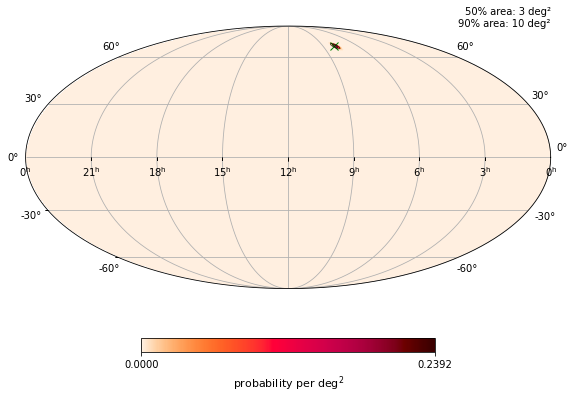

In [13]:
true_ra = injection_parameters['ra']
true_dec = injection_parameters['dec']

# We don't save skymap this time, just plot
sealcal.localization.plot_skymap(logprob_skymap, true_ra = true_ra, true_dec = true_dec)

In [14]:
# Confidence area
sealcal.localization.confidence_area(logprob_skymap, [50, 90])

array([2.96375568, 9.8354724 ])

In [15]:
# Search area
sealcal.localization.search_area(logprob_skymap, true_ra, true_dec)

0.354077006573461

## BBH



In [16]:
injection_parameters = dict(mass_1 = 16, mass_2 = 14,a_1=0, a_2=0, tilt_1=0,tilt_2=0, phi_12=0, phi_jl=0,
                            luminosity_distance=900., theta_jn=0.4, psi=2.6, phase=1.3, geocent_time=1126259642.4, ra=2.1, dec=1.2)

duration = 16. # 16
sampling_frequency = 4096


waveform_arguments = dict(waveform_approximant='IMRPhenomPv2', minimum_frequency=20.)


waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration, sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments)

det_names = ['H1', 'L1', 'V1']

ifos = bilby.gw.detector.InterferometerList(det_names)

'''
psd_files = ['example_inputs/H1_psd.txt','example_inputs/L1_psd.txt', 'example_inputs/V1_psd.txt']
# if your want to use your own PSD
for i in range(len(ifos)):
    det = ifos[i]
    psd_file = psd_files[i]
    psd = bilby.gw.detector.PowerSpectralDensity(psd_file=psd_file)
    det.power_spectral_density = psd 
'''
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration,
    start_time=injection_parameters['geocent_time'] - duration + 1)

ifos.inject_signal(waveform_generator=waveform_generator,
                parameters=injection_parameters)



13:57 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:57 bilby INFO    : Injected signal in H1:
13:57 bilby INFO    :   optimal SNR = 14.55
13:57 bilby INFO    :   matched filter SNR = 15.26-0.90j
13:57 bilby INFO    :   mass_1 = 16
13:57 bilby INFO    :   mass_2 = 14
13:57 bilby INFO    :   a_1 = 0
13:57 bilby INFO    :   a_2 = 0
13:57 bilby INFO    :   tilt_1 = 0
13:57 bilby INFO    :   tilt_2 = 0
13:57 bilby INFO    :   phi_12 = 0
13:57 bilby INFO    :   phi_jl = 0
13:57 bilby INFO    :   luminosity_distance = 900.0
13:57 bilby INFO    :   theta_jn = 0.4
13:57 bilby INFO    :   psi = 2.6
13:57 bilby INFO    :   phase = 1.3
13:57 bilby INFO    :   geocent_time = 1126259642.4
13:57 bilby INFO    :   ra = 2.1
13:57 bilby INFO    :   dec = 1.2
13:57 bilby INFO    : Injected signal in L1:
13:57

[{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [17]:
# Generate SNR and sigma
snr_list, sigma_list = sealsim.generating_data.snr_generator(ifos, waveform_generator, injection_parameters)

injection tc:  1126259642.4
Max snr time: 1126259642.3863282, SNR = 15.24887827624221


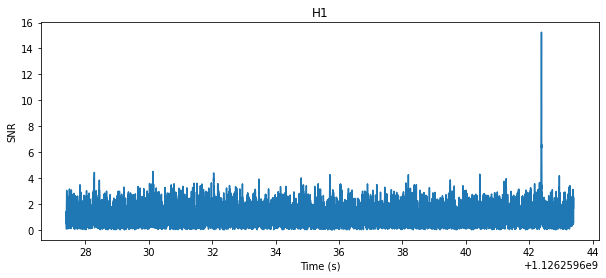

Max snr time: 1126259642.387549, SNR = 10.663990173824466


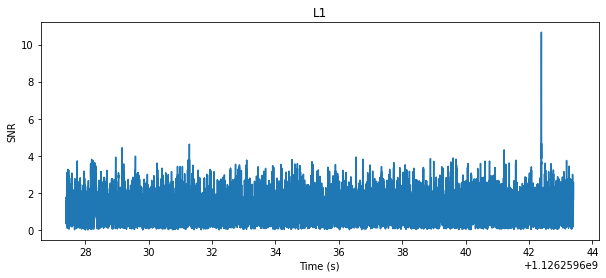

Max snr time: 1126259642.3819337, SNR = 13.722514634501726


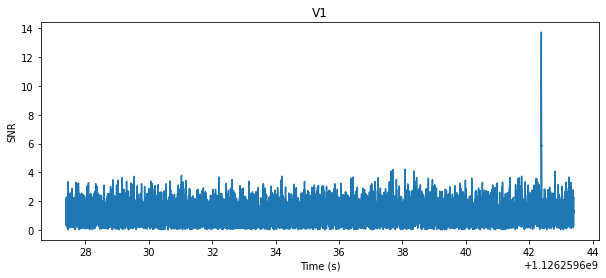

Max network SNR:  23.120475406124125


In [18]:
# Take a look at SNR we have
print('injection tc: ', injection_parameters['geocent_time'])
max_snr_sq = 0

det_id = 0
for snr in snr_list:
    peak = abs(snr).numpy().argmax()
    snrp = snr[peak]
    max_snr_sq += abs(snrp)**2
    time = snr.sample_times[peak]
    print('Max snr time: {}, SNR = {}'.format( time , abs(snrp)) )
    
    plt.figure(figsize=[10, 4])
    plt.plot(snr.sample_times, abs(snr))
    plt.ylabel('SNR')
    plt.xlabel('Time (s)')
    plt.title(det_names[det_id])
    plt.show()
    
    det_id +=1

print('Max network SNR: ', max_snr_sq**0.5)

In [19]:

nthread = 4

det_names = ['H1', 'L1', 'V1']

# Rearrange some variables: snr_arrays, time_arrays are 1-D array
time_arrays = np.array([])
snr_arrays = np.array([])
ntimes_array = np.array([])
for snr in snr_list:
    snr_arrays = np.append(snr_arrays, snr.data)
    time_arrays = np.append(time_arrays, snr.sample_times.data)
    ntimes_array = np.append(ntimes_array, len(snr.sample_times.data))

max_snr = max_snr_sq**0.5
sigma_array = np.array(sigma_list)

start_time = injection_parameters['geocent_time'] - 0.01
end_time = injection_parameters['geocent_time'] + 0.01

seal_sim = seal.Seal('example_outputs/sealconfig_bilby_lhv_BBH.txt')
logprob_skymap, timecost = seal_sim.localize( det_names, time_arrays, snr_arrays, max_snr, sigma_array, ntimes_array, start_time, end_time,
         nthread,  timecost=True, interp_factor=8)

print("Timecost (s): ", timecost)

Timecost (s):  1.068436861038208


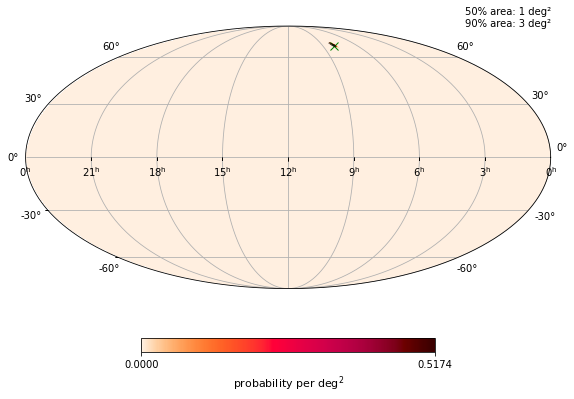

In [20]:
true_ra = injection_parameters['ra']
true_dec = injection_parameters['dec']

# We don't save skymap this time, just plot
sealcal.localization.plot_skymap(logprob_skymap, true_ra = true_ra, true_dec = true_dec)

In [21]:
# Confidence area
sealcal.localization.confidence_area(logprob_skymap, [50, 90])

array([1.35073821, 3.48831421])

In [22]:
# Search area
sealcal.localization.search_area(logprob_skymap, true_ra, true_dec)

0.7606098659726199